<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/5_Diffusion_v3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：Diffusionモデルで画像を生成する
### 概要：
- Diffusion Model
- MNIST画像を生成する
  - FMNIST、CIFAR10画像も生成可能

- 注意
  - 訓練に時間がかかる
  - 授業時間内では epoch数は10程度（約1時間）
    - 精度の良い画像生成には十分な訓練ができない
    - 自宅でepoch数を可能な限り大きくして確認する（50～100等）

  
<br>
&copy; 2023-2024 Hiro Kimura
<br>

## ポイント

- データセットにはMNIST（FMNIST、CIFAR10）を用いる

- PyTorch Tutorialを参考にしているが，UNetは用いない

<!--
  - https://github.com/Jackson-Kang/Pytorch-Diffusion-Model-Tutorial
-->

- 参考：斎藤康毅：ゼロから作る Deep Learning 5、オライリー


# 実習の準備をする
  1. GPUを確認する
  1. タイムゾーンを東京にする
  1. Google Driveをマウントする
  1. ライブラリを導入する
  1. 開発環境を整備する





## GPUを確認する

In [ ]:
import torch

# GPUの設定であればcuda，そうでなければcpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# 割り当てられたGPUを調べる
!nvidia-smi

Tue Jul  9 02:29:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## タイムゾーンを東京に変更する

In [ ]:
!date

Tue Jul  9 02:29:56 AM UTC 2024


In [ ]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

In [ ]:
!date

Tue Jul  9 11:29:57 AM JST 2024


## Google Driveをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 作業フォルダ（作業ディレクトリ）を作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_diffusion"
if not os.path.exists(chap_dir): # ディレクトリが存在していなければ
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

os.chdir(chap_dir) # 今回の作業ディレクトリに移動する
os.getcwd() # 現在の作業ディレクトリを表示する

'/content/drive/MyDrive/practice/chap_diffusion'

## ライブラリーを導入する

1. ライブラリーを導入する

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [ ]:
! pwd
! ls -l

/content/drive/MyDrive/practice/chap_diffusion
total 4
drwx------ 2 root root 4096 Jul  8 14:14 dataset


In [ ]:
# !pip install vit-pytorch
# !pip install timm

# データの準備をする

1. MNIST <br>
  - 28 x 28，8bit gray scale
  - 10 classes
  - trainデータセット: 60,000画像
  - testデータセット： 10,000画像

1. ./dataset/' フォルダにダウンロードする
  - ダウンロード時に，データの前処理を行う
    - Tensor型への変換
    - スケール変換（標準化）：今回は省略

1. データ分割する
1. データローダを作成する


In [ ]:
# データを格納するディレクトリを作成する

data_dir = "./dataset"
if not os.path.exists(data_dir): # ディレクトリが存在していなければ
    os.makedirs(data_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

# 現在の作業ディレクトリを確認する
!pwd
!ls -F

/content/drive/MyDrive/practice/chap_diffusion
dataset/


以下のセルでエラーが出る場合は，
1. Webブラウザで，パソコンに手動でダウンロードし，
1. パソコンから，datasetに手動でアップロードする

In [ ]:
# データセット
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset = 'MNIST' # CIFAR10 or MNIST or FashionMNIST
# dataset = 'FashionMNIST' # CIFAR10 or MNIST or FashionMNIST
# dataset = 'CIFAR10' # CIFAR10 or MNIST or FashionMNIST
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

# データ変換（デフォルトは点さー変換のみ）
transform = transforms.Compose([
        transforms.ToTensor(),
])

# データセットのダウンロード
if dataset == 'CIFAR10':
    train_dataset = CIFAR10(data_dir, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(data_dir, transform=transform, train=False, download=True)
elif dataset == 'FashionMNIST':
    train_dataset = FashionMNIST(data_dir, transform=transform, train=True, download=True)
    test_dataset  = FashionMNIST(data_dir, transform=transform, train=False, download=True)
else:
    # # MNISTの場合は正規化の処理も
    # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = MNIST(data_dir, transform=transform, train=True, download=True)
    test_dataset  = MNIST(data_dir, transform=transform, train=False, download=True)



In [ ]:
! pwd
! ls -l ./dataset

/content/drive/MyDrive/practice/chap_diffusion
total 4
drwx------ 3 root root 4096 Jul  8 14:14 MNIST


In [ ]:
# データローダ
seed = 24

torch.manual_seed(seed)
np.random.seed(seed)

train_batch_size = 128
inference_batch_size = 64

# データローダのオプション設定
kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

### データ分割とデータローダの作成



In [ ]:
# データセットのサイズを辞書に格納する
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

# 正解ラベル名（クラス名）をリストに格納する
class_names = train_dataset.classes

In [ ]:
# データを確認する
print(f"データセットのデータ数：{dataset_sizes}")
print(f"正解ラベル名：{class_names}")

データセットのデータ数：{'train': 60000, 'val': 10000}
正解ラベル名：['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 画像表示ツールを作成する
- 入力画像はテンソル化されたデータ
  - データの並び順の変換
    - テンソル型：chan, height, width の順
    - PIL：height, width, chan の順

<!--
  - 標準化の処理を元に戻す
    - 平均値と標準偏差で標準化した値
    - 表示は画素値に対応した値
-->

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# テンソル化された画像データを表示する関数を作成する
def imshow(inp, title=None):

    # ImageNet画像の場合は以下も
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean # 標準化（(org-mean)/std）されていたデータを元に戻す

    # データ変換
    inp = np.clip(inp, 0, 1) # [0, 1]以外のデータを削除する
    npimg = inp.detach().numpy() # Tensor型imgから画素値を取得してNumpy型配列に変換
    img = npimg.transpose((1, 2, 0)) # C, H, Wの順番をH, W, Cに変換する

    # 画像表示
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
# 各クラスのサンプルを一枚ずつ取得する
import numpy as np

class_ids, sample_indices = np.unique(train_dataset.targets, return_index=True)
print(f'クラス数：{len(class_ids)}, 画像データ数：{len(sample_indices)}')

クラス数：10, 画像データ数：10


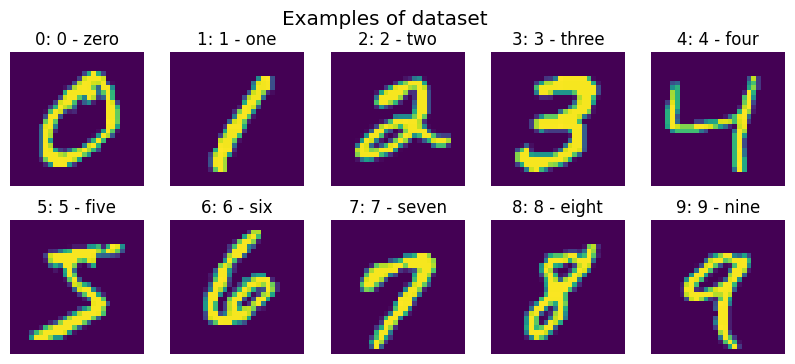

In [ ]:
# 各クラス一枚ずつサンプル画像を表示する
# 画像表示領域
fig = plt.figure(figsize=(10, 4))

# 画像全体のタイトル
fig.suptitle("Examples of dataset", fontsize="x-large")

for i in class_ids: # クラス番号順に0～9
    img = train_dataset.data[sample_indices[i]] # 画像データ
    class_name = train_dataset.classes[i] # クラス名

    # 画像表示エリアを2行5列に分割し，左上から順番に0～9
    ax = fig.add_subplot(2, 5, i + 1) # i+1番目の領域に
    ax.set_title(f"{i}: {class_name}") # クラス番号：クラス名の形式を
    ax.set_axis_off()
    # ax.imshow(img, cmap="gray") # 白黒画像として
    ax.imshow(img)

plt.show() # 表示する

# 学習モデルを定義する

<!--
1. UNet
  - timm: Pytorch Image Models (timm)
    https://timm.fast.ai/
-->

## 位置エンコーディング
- Sinusoidal embedding for diffusion timestep


In [ ]:
class SinusoidalPosEmb(nn.Module):
    # 時間ステップをエンベッディングするためのクラス
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # sinとcosを使って位置エンベッディングを生成
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

## a simple stacked-convolution model with various dilations
 - 一般には，ここにUNetを用いる

In [ ]:
# Hyperparameters for DDMP
timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

hidden_dims = [hidden_dim for _ in range(n_layers)]

In [ ]:
class ConvBlock(nn.Conv2d):
    # ConvBlock: 畳み込みブロックを定義するクラス
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        # padding='same'は以下で適切なパディングサイズを自動計算
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y

In [ ]:
# # 必要なライブラリをインポート
# import torch
# import torch.nn as nn

# Denoiserモデルの定義
# ノイズが付加された画像からノイズを除去するための畳み込みニューラルネットワーク
class Denoiser(nn.Module):

    # コンストラクタ
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim=256, n_times=1000):
        # 親クラスのコンストラクタを呼び出し
        super(Denoiser, self).__init__()

        # 画像のチャンネル数を取得
        _, _, img_C = image_resolution

        # 拡散時間のエンベッディングを定義
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        # 入力プロジェクションレイヤーを定義
        # 入力チャンネルを最初の隠れ層の次元に変換する
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        # 拡散時間プロジェクションを定義
        # 拡散時間プロジェクションを最初の隠れ層の次元に変換する
        self.time_project = nn.Sequential(
            ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
            ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1)
        )

        # 畳み込み層を定義
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        # 畳み込み層をループで追加する
        for idx in range(1, len(hidden_dims)):
            # 畳み込み層を追加（隣接する層間で次元数を増やす）
            self.convs.append(ConvBlock(
                hidden_dims[idx-1],
                hidden_dims[idx],
                kernel_size=3,
                dilation=3**((idx-1)//2),
                activation_fn=True,
                gn=True,
                gn_groups=8
            ))

        # 出力を変換するための畳み込みブロックを定義
        # 最後の畳み込み層の次元を基の画像のチャネル数に変換するための畳み込みブロック
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)

    # 順伝播を定義
    def forward(self, perturbed_x, diffusion_timestep):
        # 入力データを設定（ノイズが付加された画像）
        y = perturbed_x

        # 拡散時間のエンベッディングを取得
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        # 拡散時間エンベッディングを適切な形状に変換
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        # 入力データを適切な形状に変換
        y = self.in_project(y)

        # 畳み込み層を適用
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual=True) # 残差接続あり

        # 出力データを適切な形状に変換
        y = self.out_project(y)

        # 最終的な出力を返す
        return y

In [ ]:
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps).to(device)

In [ ]:
model

Denoiser(
  (time_embedding): SinusoidalPosEmb()
  (in_project): ConvBlock(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_project): Sequential(
    (0): ConvBlock(
      256, 256, kernel_size=(1, 1), stride=(1, 1)
      (activation_fn): SiLU()
    )
    (1): ConvBlock(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (convs): ModuleList(
    (0): ConvBlock(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-2): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation_fn): SiLU()
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    )
    (3-4): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3)
      (activation_fn): SiLU()
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    )
    (5-6): 2 x ConvBlock(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(9, 9), dilation=(9, 9)
      (activation_fn): SiLU()
      (group_norm): Gro

## Gaussian Diffusion

In [ ]:
# nn.Moduleを継承するDiffusionクラスの定義
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
        super(Diffusion, self).__init__()

        self.n_times = n_times  # 時間ステップの数
        self.img_H, self.img_W, self.img_C = image_resolution  # 画像の解像度（高さ、幅、チャンネル数）

        self.model = model  # 予測モデル

        # ベータの線形スケジュールを定義（DDPM論文に基づく）
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device)  # DDPM論文に基づく
        self.sqrt_betas = torch.sqrt(betas)  # betasの平方根

        # 順方向の拡散カーネルのalphaパラメータを定義（DDPM論文に基づく）
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device  # デバイス（例: 'cuda'）

    def extract(self, a, t, x_shape):
        """
        Lucidrainsの実装から引用
        https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape  # バッチサイズを取得
        out = a.gather(-1, t)  # 指定されたインデックスでテンソルを収集
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))  # 形状を再整形して返す

    # [-1, 1]の範囲にスケールするメソッド
    def scale_to_minus_one_to_one(self, x):
        # DDPM論文に従い、逆プロセスネットワークのトレーニングに重要な正規化を行う
        return x * 2 - 1

    # [0, 1]の範囲にスケールを戻すメソッド
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    # ノイズを加えて画像を生成するメソッド
    def make_noisy(self, x_zeros, t):
        # x_0をx_tに摂動（forward diffusion kernelによる）
        epsilon = torch.randn_like(x_zeros).to(self.device)  # ランダムノイズを生成

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # ノイズサンプルを生成: 固定分散スケジュールによる順方向プロセス
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon  # ノイズサンプルとノイズを返す

    # Forwardプロセスを実行するメソッド
    def forward(self, x_zeros):
        # 入力画像を[-1, 1]の範囲にスケール
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)  # 入力を正規化

        B, _, _, _ = x_zeros.shape  # バッチサイズを取得

        # (1) 拡散時間ステップをランダムに選択
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) 順方向の拡散プロセス: 固定分散スケジュールでx_zerosに摂動（ノイズ）を加える
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) 拡散時間ステップtで摂動（ノイズ）を付加されたデータを使ってノイズ(epsilon)を予測
        pred_epsilon = self.model(perturbed_images, t)

        # 摂動画像（ノイズを付加された画像）、実際のノイズ、予測されたノイズを返す
        return perturbed_images, epsilon, pred_epsilon

    # 特定の時間ステップでデノイズするメソッド
    def denoise_at_t(self, x_t, timestep, t):
        # バッチサイズを取得
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)  # ランダムノイズを生成
        else:
            z = torch.zeros_like(x_t).to(self.device)  # 最後のステップ（t=0）ではノイズなし

        # 推論時には、予測されたノイズ(epsilon)を使って摂動データサンプルを復元
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # 時間tでノイズ除去を行い、予測されたノイズを利用
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1 - alpha) / sqrt_one_minus_alpha_bar * epsilon_pred) + sqrt_beta * z

        return x_t_minus_1.clamp(-1., 1)  # 値を-1から1の範囲に制限して返す

    # サンプリングメソッド
    def sample(self, N):
        # ランダムノイズベクトルから開始し、x_0を生成（シンプルのため、x_Tをx_tとする）
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # 自己回帰的にx_Tからx_0までノイズ除去を行う
        # ループを self.n_times - 1 から 0 まで回し、ノイズを一歩ずつ除去する
        for t in range(self.n_times - 1, -1, -1):
            # tをテンソルtimestepとして作成し、N個のバッチに適用する
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)

            # 現在のノイズ状態から次のステップへのノイズ除去を行う
            x_t = self.denoise_at_t(x_t, timestep, t)

        # x_0を0～1の範囲に正規化
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0  # 生成された画像を返す




In [ ]:
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=device).to(device)

In [ ]:
# Model Hyperparameters

lr = 5e-5

In [ ]:
# Optimizer
optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

# Forward Processを確認する

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


### ノイズを付加した画像、付加したノイズ、それを予測したノイズを生成
1. test_loaderから取得した画像xに対し、
  - inference_batch_size（= 64）個
1. ランダムな時間ステップtでのノイズを付加した画像（perturbed_images）を取得
  - 付加したノイズ（epsilon）
  - 付加したノイズを予測したノイズ（pred_epsilon）
1. 画像データの範囲を[0, 1]に変換

In [ ]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(device)
    # ノイズが付加された画像、付加したノイズ、予測したノイズ
    perturbed_images, epsilon, pred_epsilon = diffusion(x)

    # 画像データは[-1, 1]の範囲
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [ ]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

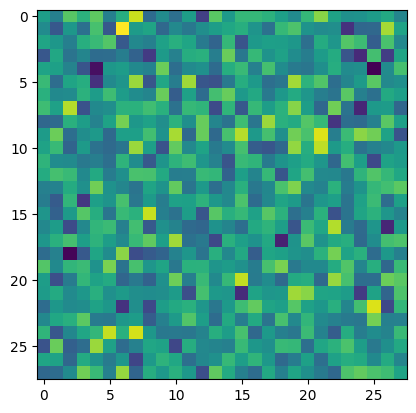

In [ ]:
show_image(perturbed_images, idx=0)

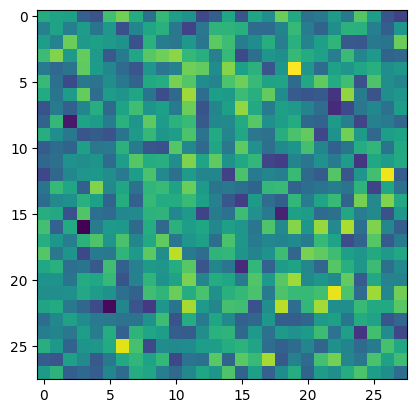

In [ ]:
show_image(perturbed_images, idx=1)

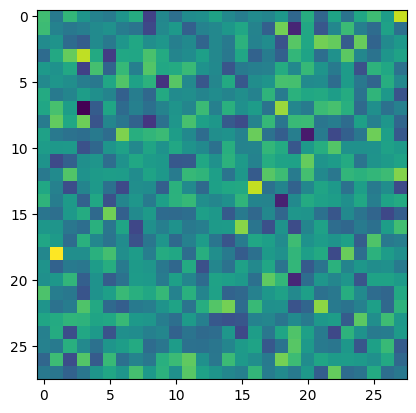

In [ ]:
show_image(perturbed_images, idx=2)

# Denoising Diffusion Probalilistic Models（DDPMs）を訓練する

- epochs = 10 で、60 ～ 70 分
  - 10 epochs程度ではきれいな画像は生成できないが。。。


In [ ]:
# epochs originally sets 200
# but it takes 7 min / epoch
# so for a tiny trial we set epochs 10, it will take 70 min.
# epochs = 200
epochs = 10

In [ ]:
print("Start training DDPMs...")
# モデルを訓練モードへ
# 訓練時だけに適用される層（ドロップアウトやバッチ正則化など）をイネーブルに

model.train()

for epoch in range(epochs):
    # エポック内の全バッチの累積損失
    noise_prediction_loss = 0

    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):

        # 前回バッチの勾配をクリア
        optimizer.zero_grad()

        # 画像データをGPUへ
        x = x.to(device)

        # ノイズの付加と予測
        noisy_input, epsilon, pred_epsilon = diffusion(x)

        # 実際のノイズと予測したノイズの誤差を計算
        loss = denoising_loss(pred_epsilon, epsilon)

        # 現在のバッチの損失をエポック内の累積損失に加算
        noise_prediction_loss += loss.item()

        # 勾配を計算して誤差逆伝播
        loss.backward()

        # パラメータの更新
        optimizer.step()

    # エポック内の平均損失
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)

print("Finish!!")

Start training DDPMs...


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 469/469 [05:36<00:00,  1.39it/s]

	Epoch 1 complete! 	Denoising Loss:  0.10018621697130366



100%|██████████| 469/469 [05:41<00:00,  1.37it/s]

	Epoch 2 complete! 	Denoising Loss:  0.0410396559163928



100%|██████████| 469/469 [05:41<00:00,  1.37it/s]

	Epoch 3 complete! 	Denoising Loss:  0.035497126523723714



100%|██████████| 469/469 [05:41<00:00,  1.37it/s]

	Epoch 4 complete! 	Denoising Loss:  0.03269797213311888



100%|██████████| 469/469 [05:41<00:00,  1.37it/s]

	Epoch 5 complete! 	Denoising Loss:  0.031710424504250795



100%|██████████| 469/469 [05:41<00:00,  1.37it/s]

	Epoch 6 complete! 	Denoising Loss:  0.030732332036281243
Finish!!


# 画像生成（推論）
- Sample images from noise
- inference_batch_size（=64）個の画像生成

In [ ]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

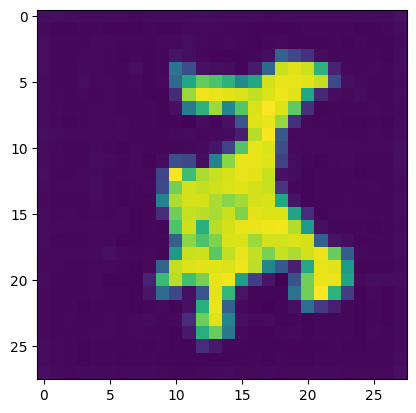

In [ ]:
show_image(generated_images, idx=0)

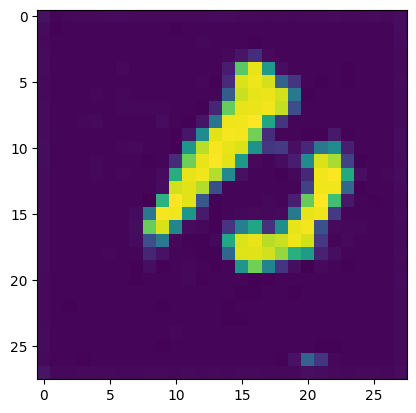

In [ ]:
show_image(generated_images, idx=1)

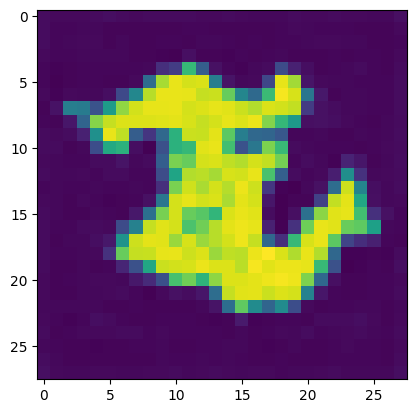

In [ ]:
show_image(generated_images, idx=2)

# 評価
- Comparision with ground-truth samples

In [ ]:
def draw_sample_image(x, postfix):

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

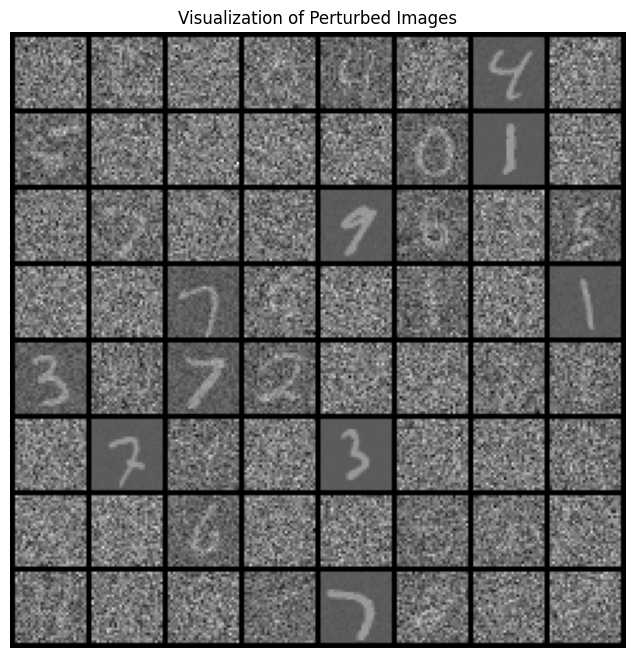

In [ ]:
draw_sample_image(perturbed_images, "Perturbed Images")

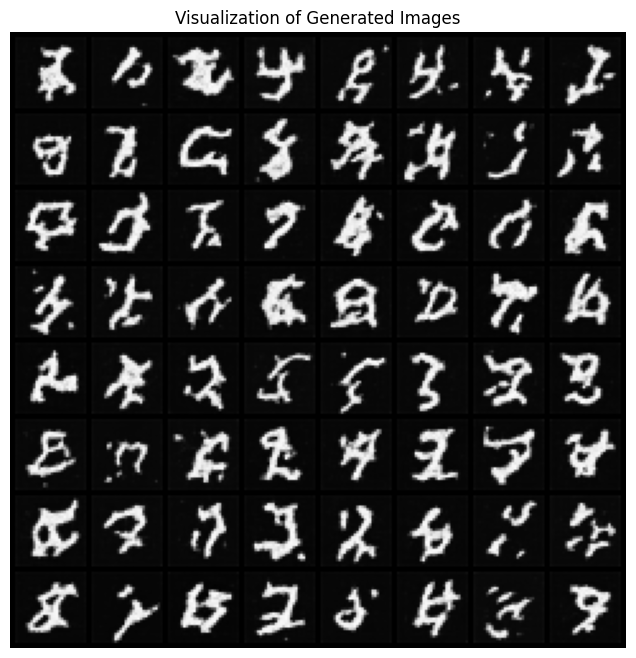

In [ ]:
draw_sample_image(generated_images, "Generated Images")

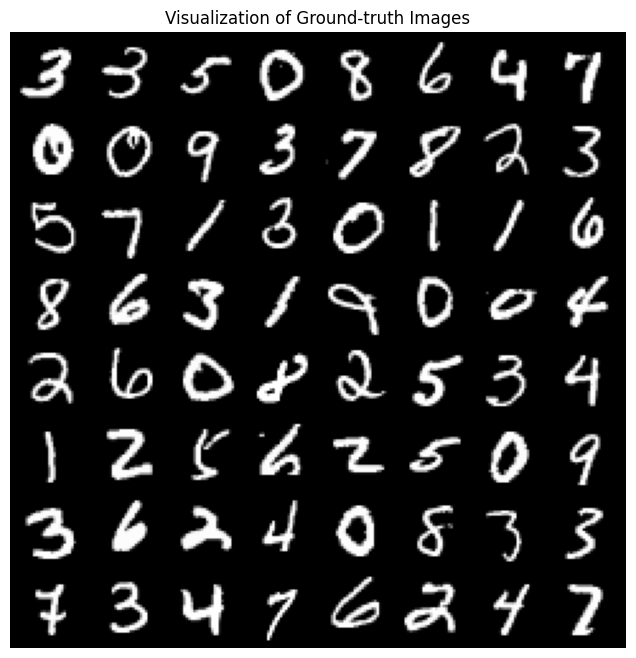

In [ ]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")

# 課題

1. epoch数を増やしてみる

    - epoch = 30、epoch = 50、epoch = 100等 にして、
    - 生成画像の画質を確認する
    
<!--
1. スケジューラの効果を確かめる

  - train引数の引数からschedulerを除く
  ```
    # loss, acc = train(model, criterion, optimizer, train_dataloader, device) # no scheduler
    loss, acc = train(model, criterion, optimizer, train_dataloader, device, scheduler=scheduler) # with scheduler
  ```
  - パラメータ値を保存するファイルも変更する
  ```
    torch.save(best_model_wts, './vit_schdlr_best_wts_gender01.pkl') # ViT
    # torch.save(best_model_wts, './vit_no-schdlr_best_wts_gender01.pkl') # ViT no scheduler
  ```
  - 混同行列で評価結果を比較してみる

1. CNNモデルと比較してみる
  1. modelをResNet50に変更する
  ```
    # # CNNモデル名をしていして事前学習済みモデルを取得し定義
    # model = timm.create_model('resnetv2_50.a1h_in1k', pretrained=True, num_classes=2)
    # model = model.to(device)
  ```
  1. epoch数を100程度に変更する
  ```
    # 訓練の長さ
    # EPOCHS=100 # ResNet50: GPUで5分程度
    EPOCHS=500 #  ViT: GPUで50分程度
  ```
  1. パラメータ値を保存するファイルも変更する
  ```
    torch.save(best_model_wts, './vit_schdlr_best_wts_gender01.pkl') # ViT
    # torch.save(best_model_wts, './resnet50_best_wts_gender01.pkl') # ResNet50
  ```
  1. 画像を保存するファイルも変更する
  ```
    # ファイル保存
    fig.savefig('./ViT_no-schdlr_cm.png')
    # fig.savefig('./ResNet50_no-schdlr_cm.png')
  ```
  1. 再実行する
    1. ランタイム/ランタイムを接続解除して削除
    1. ランタイム/すべてのセルを実行
-->

# まとめ

- 拡散モデル（Diffusionモデル）は、非平衡熱力学から着想を得ている
  - 拡散過程（Forward Process）：1時刻前の画像に対してノイズを追加する過程
  - 逆拡散過程（Reverse Process）：1時刻後の画像からノイズを除去する過程
  - 時刻 t=0 で純粋な画像、時刻 t=T=1000 で完全なノイズ
  - 拡散過程では、ガウスノイズ（正規分布）を加える
  - 逆拡散過程では、「加えられたノイズ」を訓練により推測できるようにする

- 拡散モデルの特徴
  - 拡散モデルは生成モデル（確率分布モデル）である
  - 各時刻のモデルはVAEに等しい（T個のVAEモデル）
  - ただし、以下の違いがある：
    - VAEでは潜在変数zの次元が観測変数（画像） $x_0$ より小さい
    - 拡散モデルでは、zの次元数とxの次元数は等しい

- 拡散モデルの学習
  - 時刻tをベクトル化して入力データに加算することにより、T個のモデルを一つのモデルに集約する
  - 誤差
    - ノイズが少し除去された画像の差を最小化
    - 除去すべきノイズの差（加えたガウスノイズの平均値の差）を最小化